In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import gudhi
from tqdm import tqdm

In [2]:
def number_of_b0_b1(p):
    rips = gudhi.RipsComplex(points = p, max_edge_length = 2)
    s_tree = rips.create_simplex_tree(max_dimension = 2)
    diag = s_tree.persistence()
    b0, b1 = 0, 0
    for dg in diag:
        if(dg[1][1] >= 1.42 or dg[1][1] == np.inf):
            if(dg[0] == 0):
                b0 += 1
            if(dg[0] == 1):
                b1 += 1
    return b0, b1

In [3]:
def image_to_point(X):
    points = []
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if(X[i, j] == 0):
                a = np.array([i, j])
                points.append(a)
    points = np.array(points)
    return points

In [4]:
def local_merging_number(X, patches_x, patches_y, dir):
    x_b0, x_b1 = number_of_b0_b1(image_to_point(X))
    px_size = (int)(X.shape[0] / patches_x)
    py_size = (int)(X.shape[1] / patches_y)
    X1 = np.zeros([X.shape[0], X.shape[1], patches_x*patches_y]) + 255
    X2 = np.zeros([X.shape[0], X.shape[1], patches_x*patches_y]) + 255
    X1_U_X2 = np.zeros([X.shape[0], X.shape[1], patches_x*patches_y])
    i, j = 0, 0
    n, m = 0, 0
    offset = 0
    lg = np.zeros([patches_x, patches_y])
    pbar = tqdm(total= patches_x*patches_y)
    while( (i+px_size) <= X.shape[0]):
        while( (j+py_size) <= X.shape[1]):
            # print(f"patch {offset} , px = {i+1}:{i+px_size}, py = {j+1}:{j+py_size}")
            X1[i+1:i+px_size-1, j+1:j+py_size-1, offset] = np.array(X[i+1:i+px_size-1, j+1:j+py_size-1])
            x1_b0, x1_b1 = number_of_b0_b1(image_to_point(X1[:, :,offset]))

            X2[:, :, offset] = X
            X2[i:i+px_size, j:j+py_size, offset] = 255
            x2_b0, x2_b1 = number_of_b0_b1(image_to_point(X2[:, :, offset]))
            
            lg[n, m] += (x2_b0 - x_b0 + x1_b0)

            X1_U_X2[:, :, offset] = X
            X1_U_X2[i:i+px_size, j:j+py_size+1, offset] = 255 
            X1_U_X2[i+1:i+px_size-1, j+1:j+py_size-1, offset] = X1[i+1:i+px_size-1, j+1:j+py_size-1, offset] 

            cv2.imwrite(f"./images/{dir}/image_X1_{offset}.png", X1[:,:,offset])
            cv2.imwrite(f"./images/{dir}/image_X2_{offset}.png", X2[:,:,offset])
            cv2.imwrite(f"./images/{dir}/image_X1UX2_{offset}.png", X1_U_X2[:,:,offset])
            offset += 1
            j += py_size
            m += 1
            pbar.update(1)
        j = 0
        i += px_size
        m = 0
        n += 1
    pbar.close()
    return lg, X1, X2, X1_U_X2

In [26]:
img = cv2.imread('./images/simple_binary_2.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret,X = cv2.threshold(img,70,255,cv2.THRESH_BINARY)

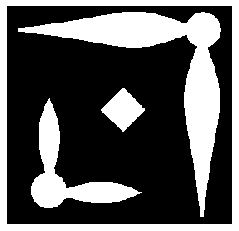

In [24]:
fig1, ax1 = plt.subplots()
ax1.axis('off')
ax1.imshow(X, cmap='Greys');

In [8]:
lg_num, x1, x2, x1_u_x2 = local_merging_number(X, 3, 3, "croped")

100%|██████████| 9/9 [00:13<00:00,  1.46s/it]


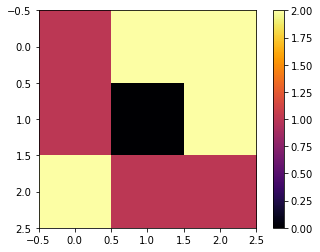

In [11]:
fig2, ax2 = plt.subplots()
im2 = ax2.imshow(lg_num, cmap='inferno', vmin=0)
plt.colorbar(im2);